# Libraries

In [1]:
import pandas as pd
from cobra.io.json import load_json_model
import numpy as np
from cobra.flux_analysis import flux_variability_analysis
import math
from tqdm import tqdm
from itertools import chain
from optlang.symbolics import Zero
from cobra.util.solver import fix_objective_as_constraint
import gurobipy as gp
from gurobipy import GRB
import math

In [2]:
def setSolverParams(model, solver, FeasibilityTol =1e-9, IntFeasTol=1e-9, OptimalityTol=1e-9):
    if solver == "gurobi":
        model.solver.problem.Params.FeasibilityTol = FeasibilityTol
        model.solver.problem.Params.IntFeasTol = IntFeasTol
        model.solver.problem.Params.OptimalityTol = OptimalityTol
        model.solver.problem.Params.Presolve = 1
        model.solver.problem.Params.Timelimit = 3600
        model.solver.problem.setParam(GRB.Param.NumericFocus, 1)
        model.solver.problem.setParam(GRB.Param.ScaleFlag, 2)

    elif solver == "cplex":
        model.solver.configuration.tolerances.feasibility = FeasibilityTol
        model.solver.configuration.tolerances.integrality = IntFeasTol
        model.solver.configuration.tolerances.optimality = OptimalityTol
        model.solver.problem.parameters.read_scale = -1
        model.solver.problem.parameters.emphasis.numerical = 1
        model.solver.problem.parameters.timelimit = 3600
        model.solver.configuration.presolve = True
        #model_engro2_thermo.solver.problem.parameters.mip.display.set(3)
        #model_engro2_thermo.solver.problem.set_results_stream()
    elif solver == "glpk":
        model.solver.configuration.tolerances.feasibility = FeasibilityTol
        model.solver.configuration.tolerances.integrality = IntFeasTol
    else:
        raise ValueError("Cannot modify tolerance params for solver " + solver)
    

# Model

In [3]:
model = load_json_model('./data/Recon3D.json')
model.solver = 'gurobi' #you can use cplex or glpk as you whish, but gurobi and cplex are usually faster
setSolverParams(model, 'gurobi')
model

Set parameter Username
Set parameter LicenseID to value 2731476
Academic license - for non-commercial use only - expires 2026-11-01


Name,Recon3D
Memory address,77a4d2809150
Number of metabolites,5835
Number of reactions,10600
Number of genes,2248
Number of groups,0
Objective expression,1.0*BIOMASS_maintenance - 1.0*BIOMASS_maintenance_reverse_5b3f9
Compartments,"cytosol, lysosome, mitochondria, endoplasmic reticulum, extracellular space, peroxisome/glyoxysome, nucleus, golgi apparatus, inner mitochondrial compartment"


In [4]:
model.objective = 'BIOMASS_reaction'

In [5]:
model.slim_optimize()

753.3364248443652

# Exofluxomics data

- We are using Exofluxomics of 7 ovarian cancer cell lines of NCI60 (https://dctd.cancer.gov/data-tools-biospecimens/data and https://www.revvity.com/ask/nci-60-cancer-cell-lines#kb-section-0).

- The Exofluxomics analysis was published in: "Metabolite profiling identifies a key role for glycine in rapid cancer cell proliferation" -  Jain et. al 2012

- NCI60 used the RPMI-1640 as growth medium

- Your paper uses 5 ovarian cancer cell lines from CCLE that are different from the ones we're going to use to define the exofluxomics (NCI60 cells). We just need an approximation of the extracellular fluxes. Keep in mind that not all cells of your paper were growing into RPMI-1640 (It's okay for this project to not care about that).

- Your paper uses HUMAN1 as GEM, while we are going to use RECON 3D for easier integration with Jain metabolites IDs





In [6]:
df_jain = pd.read_excel('./data/1218595databases1_corrected.xls', sheet_name='CORE data', index_col=1) #exoflux of NCI60
df_jain = df_jain[df_jain['Calibrated (e)']==1]
df_jain

,Method (a),Calibrated (e),UACC-257,UACC-257.1,OVCAR-8,OVCAR-8.1,OVCAR-5,OVCAR-5.1,SF-295,SF-295.1,...,SN12C,SN12C.1,MDA-MB-231/ATCC,MDA-MB-231/ATCC.1,CCRF-CEM,CCRF-CEM.1,RPMI 8226,RPMI 8226.1,SR,SR.1
Metabolite (b),,,,,,,,,,,,,,,,,,,,,
2-phosphoglycerate,IPR,1,0.010891,0.012313,0.001671,0.002037,0.004495,0.003178,0.046393,0.041708,...,0.000799,0.003414,0.003347,0.004058,0.000048,0.000353,0.003970,0.004046,0.004946,0.006281
OH-phenylpyruvate,IPR,1,0.006489,0.006301,0.003754,0.004093,0.004945,0.002575,0.061102,0.071014,...,0.004449,0.004086,-0.000016,0.000997,0.000274,-0.000045,0.005093,0.002148,0.000366,0.000388
aminoisobutyrate,HILIC,1,-0.000996,-0.001030,-0.000922,-0.003205,-0.009112,-0.003275,-0.007030,-0.006882,...,0.000038,-0.002188,-0.001644,-0.001411,-0.004358,-0.004011,-0.000541,-0.004851,-0.002008,-0.001844
3-hydroxyanthranilate,HILIC,1,0.000004,-0.000009,-0.000003,-0.000006,-0.000006,-0.000028,0.000012,0.000995,...,0.000049,0.000049,0.000025,0.000068,0.000083,0.000024,0.000104,0.000138,0.000038,-0.000011
3-phosphoglycerate,IPR,1,0.011295,0.009672,0.002216,0.001839,0.005351,0.004794,0.029259,0.027037,...,0.003098,0.002399,0.003040,0.003676,0.001776,-0.000262,0.006900,-0.001072,0.000831,0.003157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
uridine,IPR,1,-0.001730,-0.002408,-0.004089,-0.004404,-0.006982,-0.006946,0.075043,0.056388,...,-0.026612,-0.026042,-0.001166,-0.000968,-0.013973,-0.013942,-0.029317,-0.026703,-0.012063,-0.011686
valine,HILIC,1,-2.289535,-2.289212,-1.779011,-1.790573,-2.103658,-2.020315,-15.016188,-15.760112,...,-4.109991,-3.608674,-2.811156,-3.146968,-3.286169,-3.439844,-9.662331,-8.993947,-3.089847,-3.137293
xanthine,IPR,1,0.010001,0.007740,0.007553,0.007257,0.048450,0.052410,0.156952,0.117376,...,0.052171,0.051318,0.019527,0.018116,0.022432,0.023292,0.088359,0.086740,0.035188,0.039231


In [7]:
df_jain.rename(columns={'IGROV1':'IGR-OV1', 'IGROV1.1':'IGR-OV1.1'}, inplace=True)

In [8]:
cell_ids = ['IGR-OV1','IGR-OV1.1', 'OVCAR-3', 'OVCAR-3.1', 'OVCAR-4',  'OVCAR-4.1', 
            'OVCAR-5','OVCAR-5.1', 'OVCAR-8', 'OVCAR-8.1', 'SK-OV-3', 'SK-OV-3.1', 'NCI/ADR-RES', 'NCI/ADR-RES.1'] #NCI60 ovarian cancer cell lines

In [9]:
cell_ids

['IGR-OV1',
 'IGR-OV1.1',
 'OVCAR-3',
 'OVCAR-3.1',
 'OVCAR-4',
 'OVCAR-4.1',
 'OVCAR-5',
 'OVCAR-5.1',
 'OVCAR-8',
 'OVCAR-8.1',
 'SK-OV-3',
 'SK-OV-3.1',
 'NCI/ADR-RES',
 'NCI/ADR-RES.1']

In [10]:
df_jain = df_jain[cell_ids]
df_jain

,IGR-OV1,IGR-OV1.1,OVCAR-3,OVCAR-3.1,OVCAR-4,OVCAR-4.1,OVCAR-5,OVCAR-5.1,OVCAR-8,OVCAR-8.1,SK-OV-3,SK-OV-3.1,NCI/ADR-RES,NCI/ADR-RES.1
Metabolite (b),,,,,,,,,,,,,,
2-phosphoglycerate,0.004024,0.004238,0.003641,0.002481,0.008432,0.012999,0.004495,0.003178,0.001671,0.002037,-0.000364,0.000310,0.000970,0.000666
OH-phenylpyruvate,0.011052,0.016182,0.006976,0.005363,0.010825,0.007354,0.004945,0.002575,0.003754,0.004093,0.011270,0.007094,0.001803,0.004855
aminoisobutyrate,-0.000353,0.001802,0.001429,0.000837,0.001697,0.001087,-0.009112,-0.003275,-0.000922,-0.003205,-0.001814,0.001540,-0.001321,-0.003875
3-hydroxyanthranilate,-0.000048,-0.000027,-0.000020,-0.000023,-0.000015,-0.000028,-0.000006,-0.000028,-0.000003,-0.000006,-0.000037,0.000169,-0.000008,-0.000007
3-phosphoglycerate,-0.000419,0.005083,0.000907,-0.000375,0.011112,0.007249,0.005351,0.004794,0.002216,0.001839,0.001217,0.000808,0.000989,0.003787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
uridine,0.006014,0.010471,-0.002425,-0.000642,0.001338,0.001505,-0.006982,-0.006946,-0.004089,-0.004404,0.281732,0.296405,-0.015892,-0.016018
valine,-7.349679,-7.461049,-3.392893,-3.415313,-3.804516,-3.714310,-2.103658,-2.020315,-1.779011,-1.790573,-3.698666,-3.069079,-2.852274,-2.792150
xanthine,0.161968,0.161236,0.037498,0.038947,0.024761,0.024642,0.048450,0.052410,0.007553,0.007257,0.027664,0.030031,0.023520,0.024672


In [11]:
# CCLE https://sites.broadinstitute.org/ccle/ contains more than 1K human cancer cell lines with associated RNA-seq data
# Meeson et al. (your paper) used 5 of this cell lines for ovarian cancer clusterized in low and high grade based on literature)
CCLE_annotation = pd.read_csv('./data/Cell_lines_annotations_20181226.txt', index_col=0, sep='\t')
CCLE_annotation

,depMapID,Name,Pathology,Site_Primary,Site_Subtype1,Site_Subtype2,Site_Subtype3,Histology,Hist_Subtype1,Hist_Subtype2,...,Growth.Medium,Supplements,FreezingMedium,DoublingTimefromVendor,DoublingTimeCalculatedhrs,type,type_refined,PATHOLOGIST_ANNOTATION,mutRate,tcga_code
CCLE_ID,,,,,,,,,,,,,,,,,,,,,
DMS53_LUNG,ACH-000698,DMS 53,primary,lung,NS,NS,NS,carcinoma,small_cell_carcinoma,NS,...,Waymouth's+10%FBS,NaN,5%DMSO,NaN,450.0,lung_small_cell,lung_small_cell,Lung:SCLC,1.572416e+09,SCLC
SW1116_LARGE_INTESTINE,ACH-000489,SW1116,primary,large_intestine,colon,NS,NS,carcinoma,adenocarcinoma,NS,...,L15+10%FBS,NaN,5%DMSO,NaN,1232.0,colorectal,colorectal,Colorectal:Carcinoma,9.437319e+09,COAD/READ
NCIH1694_LUNG,ACH-000431,NCI-H1694,metastasis,lung,NS,NS,NS,carcinoma,small_cell_carcinoma,NS,...,DMEM:F12+5%FBS,"005 mg/ml insulin, 01 mg/ml transferrin, 30nM ...",5% DMSO,NaN,812.0,lung_small_cell,lung_small_cell,Lung:SCLC,1.095350e+08,SCLC
P3HR1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000707,P3HR-1,metastasis,haematopoietic_and_lymphoid_tissue,NS,NS,NS,lymphoid_neoplasm,Burkitt_lymphoma,NS,...,NaN,NaN,NaN,NaN,NaN,lymphoma_Burkitt,lymphoma_Burkitt,Lymphoma:NH_B_cell,1.664564e+09,DLBC
HUT78_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000509,HuT 78,primary,haematopoietic_and_lymphoid_tissue,skin,NS,NS,lymphoid_neoplasm,mycosis_fungoides-Sezary_syndrome,NS,...,NaN,NaN,NaN,NaN,NaN,lymphoma_other,T-cell_lymphoma_other,Lymphoma:NH_T_cell,1.182176e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GEO_LARGE_INTESTINE,ACH-002394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,colorectal,NaN,NaN,COAD/READ
NCIH2330_LUNG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LP6_SOFT_TISSUE,ACH-001116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
dict_meeson={
    'COV318':'high_grade',
    'CAOV3':'high_grade',
    'OAW28':'high_grade',
    '59M':'low_grade',
    'HEYA8':'low_grade',
}
for cell_id, type in dict_meeson.items():
    print(CCLE_annotation.loc[f'{cell_id}_OVARY'].Name)
    
# all cell lines of your paper are found in this CCLE annotation dataset as 'name+_OVARY'

COV318
Caov-3
OAW28
59M
Hey-A8


In [13]:
df_jain

,IGR-OV1,IGR-OV1.1,OVCAR-3,OVCAR-3.1,OVCAR-4,OVCAR-4.1,OVCAR-5,OVCAR-5.1,OVCAR-8,OVCAR-8.1,SK-OV-3,SK-OV-3.1,NCI/ADR-RES,NCI/ADR-RES.1
Metabolite (b),,,,,,,,,,,,,,
2-phosphoglycerate,0.004024,0.004238,0.003641,0.002481,0.008432,0.012999,0.004495,0.003178,0.001671,0.002037,-0.000364,0.000310,0.000970,0.000666
OH-phenylpyruvate,0.011052,0.016182,0.006976,0.005363,0.010825,0.007354,0.004945,0.002575,0.003754,0.004093,0.011270,0.007094,0.001803,0.004855
aminoisobutyrate,-0.000353,0.001802,0.001429,0.000837,0.001697,0.001087,-0.009112,-0.003275,-0.000922,-0.003205,-0.001814,0.001540,-0.001321,-0.003875
3-hydroxyanthranilate,-0.000048,-0.000027,-0.000020,-0.000023,-0.000015,-0.000028,-0.000006,-0.000028,-0.000003,-0.000006,-0.000037,0.000169,-0.000008,-0.000007
3-phosphoglycerate,-0.000419,0.005083,0.000907,-0.000375,0.011112,0.007249,0.005351,0.004794,0.002216,0.001839,0.001217,0.000808,0.000989,0.003787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
uridine,0.006014,0.010471,-0.002425,-0.000642,0.001338,0.001505,-0.006982,-0.006946,-0.004089,-0.004404,0.281732,0.296405,-0.015892,-0.016018
valine,-7.349679,-7.461049,-3.392893,-3.415313,-3.804516,-3.714310,-2.103658,-2.020315,-1.779011,-1.790573,-3.698666,-3.069079,-2.852274,-2.792150
xanthine,0.161968,0.161236,0.037498,0.038947,0.024761,0.024642,0.048450,0.052410,0.007553,0.007257,0.027664,0.030031,0.023520,0.024672


In [14]:
# we now look at the fluxes from Jain and take, for each metabolite, the min and max fluxes across the ovarian cancer cell lines only
# in this way we have a unique profile for ovarian cancer extracellualr fluxes
# We expect the cells to differentiate once we integrate RNA-seq data

# Relaxation 0.5 and 1.5

df_jain = df_jain * 5e-3 # convert fmol/cell*h to mmol/gdw*h (flux) assuming cell_volume = 2e-10
df_exo_flux = pd.DataFrame(columns=['Min', 'Max', 'relaxed_Min', 'relaxed_Max'], index=df_jain.index)
for met_name_jain, row in df_jain.iterrows():
    min_ = row.min()
    max_ = row.max()
    df_exo_flux.at[met_name_jain, 'Min'] = min_
    df_exo_flux.at[met_name_jain, 'Max'] = max_
    if (min_ < 0 and max_ > 0):
        df_exo_flux.at[met_name_jain, 'relaxed_Min'] = min_ * 1.5
        df_exo_flux.at[met_name_jain, 'relaxed_Max'] = max_ * 1.5
    elif(min_ < 0 and max_ < 0):
        df_exo_flux.at[met_name_jain, 'relaxed_Min'] = min_ * 1.5
        df_exo_flux.at[met_name_jain, 'relaxed_Max'] = max_ * 0.5
    else:
        df_exo_flux.at[met_name_jain, 'relaxed_Min'] = min_ * 0.5
        df_exo_flux.at[met_name_jain, 'relaxed_Max'] = max_ * 1.5
df_exo_flux

,Min,Max,relaxed_Min,relaxed_Max
Metabolite (b),,,,
2-phosphoglycerate,-0.000002,0.000065,-0.000003,0.000097
OH-phenylpyruvate,0.000009,0.000081,0.000005,0.000121
aminoisobutyrate,-0.000046,0.000009,-0.000068,0.000014
3-hydroxyanthranilate,-0.0,0.000001,-0.0,0.000001
3-phosphoglycerate,-0.000002,0.000056,-0.000003,0.000083
...,...,...,...,...
uridine,-0.00008,0.001482,-0.00012,0.002223
valine,-0.037305,-0.008895,-0.055958,-0.004448
xanthine,0.000036,0.00081,0.000018,0.001215


In [15]:
df_dict_met_rxn = pd.read_excel('./data/Liaskos_et_al.xlsx', sheet_name='Mapping_mets_IDs', index_col=0)
df_dict_met_rxn

,Metabolite ID Recon3D
Metabolite Jain et al.,
2-phosphoglycerate,2pg_e
OH-phenylpyruvate,34hpp_e
aminoisobutyrate,3aib_e
3-hydroxyanthranilate,3hanthrn_e
3-phosphoglycerate,3pg_e
...,...
uridine,uri_e
valine,val_L_e
xanthine,xan_e


In [16]:
df_exo_flux = df_exo_flux.join(df_dict_met_rxn, how='left')
df_exo_flux

,Min,Max,relaxed_Min,relaxed_Max,Metabolite ID Recon3D
Metabolite (b),,,,,
2-phosphoglycerate,-0.000002,0.000065,-0.000003,0.000097,2pg_e
OH-phenylpyruvate,0.000009,0.000081,0.000005,0.000121,34hpp_e
aminoisobutyrate,-0.000046,0.000009,-0.000068,0.000014,3aib_e
3-hydroxyanthranilate,-0.0,0.000001,-0.0,0.000001,3hanthrn_e
3-phosphoglycerate,-0.000002,0.000056,-0.000003,0.000083,3pg_e
...,...,...,...,...,...
uridine,-0.00008,0.001482,-0.00012,0.002223,uri_e
valine,-0.037305,-0.008895,-0.055958,-0.004448,val_L_e
xanthine,0.000036,0.00081,0.000018,0.001215,xan_e


In [17]:
df_exo_flux.loc[df_exo_flux['Metabolite ID Recon3D']=='tdechola_e/tdchola_e']
df_exo_flux.at['glycodeoxycholate/glycochenodeoxycholate', 'Metabolite ID Recon3D'] = 'dgchol_e'
df_exo_flux.at['taurodeoxycholate/taurochenodeoxycholate', 'Metabolite ID Recon3D'] = 'tdchola_e'

In [18]:
def double_nth_underscore(text, n=2):
    underscores = 0
    result = []
    for char in text:
        if char == '_':
            underscores += 1
            if underscores == n:
                result.append('__')
            else:
                result.append('_')
        else:
            result.append(char)
    return ''.join(result)

model_met_ids = [met.id for met in model.metabolites]
for index, row in df_exo_flux.iterrows():
    if(row['Metabolite ID Recon3D'] in model_met_ids):
        continue
    else:
        print(row['Metabolite ID Recon3D'])
        df_exo_flux.at[index, 'Metabolite ID Recon3D'] = double_nth_underscore(row['Metabolite ID Recon3D'], n=1)

print("##################################################")

model_met_ids = [met.id for met in model.metabolites]
for index, row in df_exo_flux.iterrows():
    if(row['Metabolite ID Recon3D'] in model_met_ids):
        continue
    else:
        print(row['Metabolite ID Recon3D'])
       

ala_L_e
arg_L_e
asn_L_e
asp_L_e
citr_L_e
cyst_L_e
glc_D_e
gln_L_e
glu_L_e
hcys_L_e
hom_L_e
ile_L_e
lac_L_e
leu_L_e
lys_L_e
mal_L_e
met_L_e
phe_L_e
pnto_R_e
pro_L_e
sbt_D_e
ser_L_e
thr_L_e
thyox_L_e
trp_L_e
tyr_L_e
val_L_e
##################################################


In [19]:
def double_nth_underscore(text, n=2):
    underscores = 0
    result = []
    for char in text:
        if char == '_':
            underscores += 1
            if underscores == n:
                result.append('__')
            else:
                result.append('_')
        else:
            result.append(char)
    return ''.join(result)

for index, row in df_exo_flux.iterrows():
    found_id = None
    for rxn in model.reactions:
        if(rxn.id.startswith('EX_') and len(rxn.metabolites) == 1):
            for met in rxn.metabolites:
                if(met.id == row['Metabolite ID Recon3D']):
                    found_id = rxn.id
    df_exo_flux.at[index, 'Reaction'] = found_id
df_exo_flux.loc[df_exo_flux['Reaction'].isnull()]

,Min,Max,relaxed_Min,relaxed_Max,Metabolite ID Recon3D,Reaction
Metabolite (b),,,,,,


In [20]:
df_exo_flux

,Min,Max,relaxed_Min,relaxed_Max,Metabolite ID Recon3D,Reaction
Metabolite (b),,,,,,
2-phosphoglycerate,-0.000002,0.000065,-0.000003,0.000097,2pg_e,EX_2pg_e
OH-phenylpyruvate,0.000009,0.000081,0.000005,0.000121,34hpp_e,EX_34hpp_e
aminoisobutyrate,-0.000046,0.000009,-0.000068,0.000014,3aib_e,EX_3aib_e
3-hydroxyanthranilate,-0.0,0.000001,-0.0,0.000001,3hanthrn_e,EX_3hanthrn_e
3-phosphoglycerate,-0.000002,0.000056,-0.000003,0.000083,3pg_e,EX_3pg_e
...,...,...,...,...,...,...
uridine,-0.00008,0.001482,-0.00012,0.002223,uri_e,EX_uri_e
valine,-0.037305,-0.008895,-0.055958,-0.004448,val__L_e,EX_val__L_e
xanthine,0.000036,0.00081,0.000018,0.001215,xan_e,EX_xan_e


In [21]:
medium_df = pd.read_excel('./data/Liaskos_et_al.xlsx', sheet_name='RPMI1640_medium_EX_rxns', index_col=0)
medium_df.loc['L-Hydroxyproline'] = ['EX_4hpro_LT_e'] 
#drop row Chloride
medium_df = medium_df.drop('Chloride', axis=0)
medium_df


,Reaction
RPMI 1640 medium NCI60,
Glycine,EX_gly_e
L-Arginine,EX_arg_L_e
L-Asparagine,EX_asn_L_e
L-Aspartic acid,EX_asp_L_e
L-Cystine,EX_cys_L_e
L-Glutamic Acid,EX_glu_L_e
L-Glutamine,EX_gln_L_e
L-Histidine,EX_his_L_e
L-Hydroxyproline,EX_4hpro_LT_e


In [22]:
def double_nth_underscore(text, n=2):
    underscores = 0
    result = []
    for char in text:
        if char == '_':
            underscores += 1
            if underscores == n:
                result.append('__')
            else:
                result.append('_')
        else:
            result.append(char)
    return ''.join(result)

for index, row in medium_df.iterrows():
    rxn_id = row['Reaction']
    if rxn_id in model.reactions:
        continue
    else:
        medium_df.at[index, 'Reaction'] = double_nth_underscore(medium_df.at[index, 'Reaction'], 2)

In [23]:
medium_df

,Reaction
RPMI 1640 medium NCI60,
Glycine,EX_gly_e
L-Arginine,EX_arg__L_e
L-Asparagine,EX_asn__L_e
L-Aspartic acid,EX_asp__L_e
L-Cystine,EX_cys__L_e
L-Glutamic Acid,EX_glu__L_e
L-Glutamine,EX_gln__L_e
L-Histidine,EX_his__L_e
L-Hydroxyproline,EX_4hpro_LT_e


In [24]:
for index, row in medium_df.iterrows():
    rxn_id = row['Reaction']
    if rxn_id in model.reactions:
        continue
    else:
        print(rxn_id)

In [25]:
# find all exhcngae reactions in the model
ex_rxns = []
for rxn in model.reactions:
    if rxn.id.startswith('EX_'):
        ex_rxns.append(rxn.id)
print(len(ex_rxns))

1560


In [26]:
is_medium = []
for ex in ex_rxns:
    if ex in medium_df['Reaction'].values:
        is_medium.append(1)
    else:
        is_medium.append(0)
sum(is_medium)

40

In [27]:
is_jain = []
for ex in ex_rxns:
    if ex in df_exo_flux['Reaction'].values:
        is_jain.append(1)
    else:
        is_jain.append(0)
sum(is_jain)

115

In [28]:
df_exoflux = pd.DataFrame(index=ex_rxns, columns=['in_medium', 'in_jain'])
df_exoflux['in_medium'] = is_medium
df_exoflux['in_jain'] = is_jain
df_exoflux

,in_medium,in_jain
EX_5adtststerone_e,0,0
EX_5adtststerones_e,0,0
EX_5fthf_e,0,0
EX_5htrp_e,0,0
EX_5mthf_e,0,0
...,...,...
EX_3h3mglt_e,0,0
EX_ppiogly_e,0,0
EX_sbt__D_e,0,1
EX_lvstacid_e,0,0


In [29]:
df_exo_flux

,Min,Max,relaxed_Min,relaxed_Max,Metabolite ID Recon3D,Reaction
Metabolite (b),,,,,,
2-phosphoglycerate,-0.000002,0.000065,-0.000003,0.000097,2pg_e,EX_2pg_e
OH-phenylpyruvate,0.000009,0.000081,0.000005,0.000121,34hpp_e,EX_34hpp_e
aminoisobutyrate,-0.000046,0.000009,-0.000068,0.000014,3aib_e,EX_3aib_e
3-hydroxyanthranilate,-0.0,0.000001,-0.0,0.000001,3hanthrn_e,EX_3hanthrn_e
3-phosphoglycerate,-0.000002,0.000056,-0.000003,0.000083,3pg_e,EX_3pg_e
...,...,...,...,...,...,...
uridine,-0.00008,0.001482,-0.00012,0.002223,uri_e,EX_uri_e
valine,-0.037305,-0.008895,-0.055958,-0.004448,val__L_e,EX_val__L_e
xanthine,0.000036,0.00081,0.000018,0.001215,xan_e,EX_xan_e


In [30]:
col_met_ids = []
for index, row in df_exoflux.iterrows():
    rxn = model.reactions.get_by_id(index)
    for met in rxn.metabolites:
        col_met_ids.append(met.id)
df_exoflux['Metabolite ID Recon3D'] = col_met_ids
df_exoflux

,in_medium,in_jain,Metabolite ID Recon3D
EX_5adtststerone_e,0,0,5adtststerone_e
EX_5adtststerones_e,0,0,5adtststerones_e
EX_5fthf_e,0,0,5fthf_e
EX_5htrp_e,0,0,5htrp_e
EX_5mthf_e,0,0,5mthf_e
...,...,...,...
EX_3h3mglt_e,0,0,3h3mglt_e
EX_ppiogly_e,0,0,ppiogly_e
EX_sbt__D_e,0,1,sbt__D_e
EX_lvstacid_e,0,0,lvstacid_e


In [31]:
row['in_jain']==1 & row['in_medium']==0

np.True_

In [32]:
LB = []
UB = []
is_set_list = []
for index, row in df_exoflux.iterrows():
    if(row['in_jain']==1 and row['in_medium']==1):
        LB.append(df_exo_flux.loc[df_exo_flux['Reaction']==index, 'relaxed_Min'].values[0])
        UB.append(df_exo_flux.loc[df_exo_flux['Reaction']==index, 'relaxed_Max'].values[0])
        is_set = 1
    elif(row['in_jain']==1 and row['in_medium']==0):
        jain_LB = df_exo_flux.loc[df_exo_flux['Reaction']==index, 'relaxed_Min'].values[0]
        jain_UB = df_exo_flux.loc[df_exo_flux['Reaction']==index, 'relaxed_Max'].values[0]
        if(jain_LB<0 and jain_UB>0):
            LB.append(1e-7)
            UB.append(jain_UB)
        elif(jain_LB <0 and jain_UB<0):
            LB.append(-1e-7)
            UB.append(100)
        else:
            LB.append(jain_LB)
            UB.append(jain_UB)
        is_set = 1
    else:
        is_set = 0
        LB.append(-100)
        UB.append(+100)
    is_set_list.append(is_set)
df_exoflux['LB'] = LB
df_exoflux['UB'] = UB
df_exoflux['is_set'] = is_set_list
df_exoflux

,in_medium,in_jain,Metabolite ID Recon3D,LB,UB,is_set
EX_5adtststerone_e,0,0,5adtststerone_e,-100.000000,100.000000,0
EX_5adtststerones_e,0,0,5adtststerones_e,-100.000000,100.000000,0
EX_5fthf_e,0,0,5fthf_e,-100.000000,100.000000,0
EX_5htrp_e,0,0,5htrp_e,-100.000000,100.000000,0
EX_5mthf_e,0,0,5mthf_e,-100.000000,100.000000,0
...,...,...,...,...,...,...
EX_3h3mglt_e,0,0,3h3mglt_e,-100.000000,100.000000,0
EX_ppiogly_e,0,0,ppiogly_e,-100.000000,100.000000,0
EX_sbt__D_e,0,1,sbt__D_e,0.000046,0.000514,1
EX_lvstacid_e,0,0,lvstacid_e,-100.000000,100.000000,0


In [33]:
df_exoflux.to_csv('./data/exoflux_bounds.csv')

In [34]:
#fix oxygen uptake based on literature LB = -2, UB = 0
#fix ATPM flux based on literature LB 2.576 UB 3.864
model.reactions.get_by_id('EX_o2_e').bounds = (-2, 0)
model.reactions.get_by_id('ATPM').bounds = (2.576, 3.864)

In [35]:
for index, row in tqdm(df_exoflux.iterrows(), total=df_exoflux.shape[0]):
    original_bounds = model.reactions.get_by_id(index).bounds
    model.reactions.get_by_id(index).bounds = (row['LB'], row['UB'])
    if math.isnan(model.slim_optimize()):
        print(f'Infeasible reaction: {index} with bounds {row["LB"]}, {row["UB"]}')
        model.reactions.get_by_id(index).bounds = original_bounds

 79%|███████▉  | 1234/1560 [00:11<00:10, 32.42it/s] 

Infeasible reaction: EX_sucr_e with bounds 1.9942750059574653e-06, 2.22776617839489e-05


100%|█████████▉| 1558/1560 [00:16<00:00, 58.06it/s] 

Infeasible reaction: EX_sbt__D_e with bounds 4.58713531797975e-05, 0.000513652932905718


100%|██████████| 1560/1560 [00:17<00:00, 90.85it/s]


All bounds were integrated correctly without need for MILP

In [36]:
model.objective = 'BIOMASS_reaction'

In [37]:
model.slim_optimize()

313.2604189492663

Now we run FVA to get the feasible ranges for all reactions

In [38]:
df_fva = flux_variability_analysis(model, fraction_of_optimum=0.0, processes=20)
df_fva

,minimum,maximum
24_25DHVITD3tm,0.0,100.0
25HVITD3t,0.0,100.0
COAtl,0.0,1000.0
EX_5adtststerone_e,-100.0,100.0
EX_5adtststerones_e,-100.0,100.0
...,...,...
ACMPGLUTTRsc,0.0,100.0
FVSCOAhc,0.0,100.0
MDZGLChr,0.0,100.0
TMACMPhr,0.0,100.0


In [39]:
df_fva.to_csv('./data/fva_exoflux.csv')

In [40]:
df_fva = pd.read_csv('./data/fva_exoflux.csv', index_col=0)

In [41]:
#inject bounds into the model
for index, row in df_fva.iterrows():
    model.reactions.get_by_id(index).bounds = (row['minimum'], row['maximum'])

In [42]:
#check feasibility again
print(model.slim_optimize())

313.2604189492663


# Low and high grade models

We have 7 cells belonging to 2 families: Low and High grade cancer.

We are going to work in parallel for the two families.

For each family, we select its cell lines and doubling times reported by your paper. We select the lowest and highest doubling time across all cell lines of this family. These are going to be the LB and UB for the biomass reaction associated to the generic model of family x. We also need to trasnform doubling time to  mmol/gdw*h.

flux_biomass = ln(2)/DT

In [43]:
df_cells = pd.DataFrame(columns = ['ID', 'Type', 'Doubling time'])
df_cells.loc[0] = ['COV318', 'high_grade', 50]
df_cells.loc[1] = ['CAOV3', 'high_grade', 63.95]
df_cells.loc[2] = ['OAW28', 'high_grade', 37]
df_cells.loc[3] = ['59M', 'low_grade', 48]
df_cells.loc[4] = ['HEYA8', 'low_grade', 16]
df_cells

,ID,Type,Doubling time
0,COV318,high_grade,50.00
1,CAOV3,high_grade,63.95
2,OAW28,high_grade,37.00
3,59M,low_grade,48.00
4,HEYA8,low_grade,16.00


In [44]:
#high grade min = 37.0 max = 63.95
#low grade min = 16 max = 48
#we relax by a +-20%
LB_biomass_HG = (np.log(2)/63.95) *0.8
UB_biomass_HG = (np.log(2)/37.0)*1.2

LB_biomass_LG = (np.log(2)/48)*0.8
UB_biomass_LG = (np.log(2)/16)*1.2

print(LB_biomass_HG)
print(UB_biomass_HG)

print(LB_biomass_LG)
print(UB_biomass_LG)

0.00867111406486249
0.022480449099241465
0.011552453009332421
0.0519860385419959


In [45]:
#we take the FVA from exofluxomics and for each family we set the biomass bounds and compute FVA again in order to create new bounds for each family
model.reactions.get_by_id('BIOMASS_reaction').bounds = (LB_biomass_HG, UB_biomass_HG)
print(model.slim_optimize())
df_fva_HG = flux_variability_analysis(model, fraction_of_optimum=0.0, processes=20)
df_fva_HG.to_csv('./data/fva_exoflux_HG.csv')
df_fva_HG.loc['BIOMASS_reaction']

0.022480449099241465


minimum    0.008671
maximum    0.022480
Name: BIOMASS_reaction, dtype: float64

In [46]:
model.reactions.get_by_id('BIOMASS_reaction').bounds = (LB_biomass_LG, UB_biomass_LG)
print(model.slim_optimize())
df_fva_LG = flux_variability_analysis(model, fraction_of_optimum=0.0, processes=20)
df_fva_LG.to_csv('./data/fva_exoflux_LG.csv')
df_fva_LG.loc['BIOMASS_reaction']

0.0519860385419959


minimum    0.011552
maximum    0.051986
Name: BIOMASS_reaction, dtype: float64

Basically each of these two FVA represent a model (HG anD LG)

# Minimize Sum of uptakes

In the exoflux dataset we used a column called is_set to indicate which exchange reactions had their bounds modified based on Jain data.

All the experimantal bounds were integrated. However, many exchange reactions were left as -100, +100 (this doesn't happen in reality).

For this reason, we apply the parsimonius principle to minimize the sum of uptakes BUT in such a way that the UB for growth rate can still be reached.

We will run this pipeline for our two models: low and high grade.


In [3]:
model = load_json_model('./data/Recon3D.json')
model.solver = 'gurobi'
setSolverParams(model, 'gurobi')
model

Set parameter Username
Set parameter LicenseID to value 2731476
Academic license - for non-commercial use only - expires 2026-11-01


Name,Recon3D
Memory address,7a60a3985870
Number of metabolites,5835
Number of reactions,10600
Number of genes,2248
Number of groups,0
Objective expression,1.0*BIOMASS_maintenance - 1.0*BIOMASS_maintenance_reverse_5b3f9
Compartments,"cytosol, lysosome, mitochondria, endoplasmic reticulum, extracellular space, peroxisome/glyoxysome, nucleus, golgi apparatus, inner mitochondrial compartment"


In [4]:
model.objective = 'BIOMASS_reaction'

In [5]:
df_exoflux = pd.read_csv('./data/exoflux_bounds.csv', index_col=0)
df_exoflux

,in_medium,in_jain,Metabolite ID Recon3D,LB,UB,is_set
EX_5adtststerone_e,0,0,5adtststerone_e,-100.000000,100.000000,0
EX_5adtststerones_e,0,0,5adtststerones_e,-100.000000,100.000000,0
EX_5fthf_e,0,0,5fthf_e,-100.000000,100.000000,0
EX_5htrp_e,0,0,5htrp_e,-100.000000,100.000000,0
EX_5mthf_e,0,0,5mthf_e,-100.000000,100.000000,0
...,...,...,...,...,...,...
EX_3h3mglt_e,0,0,3h3mglt_e,-100.000000,100.000000,0
EX_ppiogly_e,0,0,ppiogly_e,-100.000000,100.000000,0
EX_sbt__D_e,0,1,sbt__D_e,0.000046,0.000514,1
EX_lvstacid_e,0,0,lvstacid_e,-100.000000,100.000000,0


In [6]:
df_exoflux["is_set"].sum()

np.int64(115)

In [7]:
df_fva_LG = pd.read_csv('./data/fva_exoflux_LG.csv', index_col=0)
df_fva_HG = pd.read_csv('./data/fva_exoflux_HG.csv', index_col=0)

In [ ]:
for index, row in df_fva_LG.iterrows():
    model.reactions.get_by_id(index).bounds = (row['minimum'], row['maximum'])

obj_var_vars = []
for index, row in df_exoflux.iterrows():
    if model.reactions.get_by_id(index).lower_bound < -1e-6:
        if row.is_set == 0:
            obj_var_vars.append(model.reactions.get_by_id(index).reverse_variable)
            

#we take the reverse variable of each reaction flux. The reverse variable is between [0, |LB|]. It's always a positive number.
#cobra always return the net flux for each reactions as the difference between the forward and reverse variables.
#we want to minimize the negative flux of these reactions = uptake fluxes

original_biomass_bounds = model.reactions.get_by_id('BIOMASS_reaction').bounds
model.reactions.get_by_id('BIOMASS_reaction').bounds = (original_biomass_bounds[1]*0.99, original_biomass_bounds[1])

obj_var = sum(obj_var_vars)
model.objective = obj_var
model.objective_direction = 'min'
X = model.slim_optimize()
print("MIN sum of uptake fluxes for LG: ", X)

#now we add a constraint to the model 
min_sum_up = model.problem.Constraint(
    obj_var,
    ub=X*1.1)
model.add_cons_vars([min_sum_up])

#we relax biomass bounds back to original
model.reactions.get_by_id('BIOMASS_reaction').bounds = original_biomass_bounds

model.objective = "BIOMASS_reaction"
model.objective_direction = "max"

#compute FVA again
df_fva_LG_min_sum = flux_variability_analysis(model, fraction_of_optimum=0.0, processes=20)
df_fva_LG_min_sum.to_csv('./data/fva_exoflux_LG_min_sum.csv')

In [9]:
model = load_json_model('./data/Recon3D.json')
model.solver = 'gurobi'
setSolverParams(model, 'gurobi')
model

Name,Recon3D
Memory address,7d5fe508f2b0
Number of metabolites,5835
Number of reactions,10600
Number of genes,2248
Number of groups,0
Objective expression,1.0*BIOMASS_maintenance - 1.0*BIOMASS_maintenance_reverse_5b3f9
Compartments,"cytosol, lysosome, mitochondria, endoplasmic reticulum, extracellular space, peroxisome/glyoxysome, nucleus, golgi apparatus, inner mitochondrial compartment"


In [10]:
for index, row in df_fva_HG.iterrows():
    model.reactions.get_by_id(index).bounds = (row['minimum'], row['maximum'])

obj_var = None
for index, row in df_exoflux.iterrows():
    if model.reactions.get_by_id(index).lower_bound < -1e-6:
        if row.is_set == 0:
            if(obj_var is None):
                obj_var = model.reactions.get_by_id(index).reverse_variable
            else:
                obj_var = obj_var + model.reactions.get_by_id(index).reverse_variable
            

#we take the reverse variable of each reaction flux. The reverse variable is between [0, |LB|]. It's always a positive number.
#cobra always return the net flux for each reactions as the difference between the forward and reverse variables.
#we want to minimize the negative flux of these reactions = uptake fluxes

original_biomass_bounds = model.reactions.get_by_id('BIOMASS_reaction').bounds
model.reactions.get_by_id('BIOMASS_reaction').bounds = (original_biomass_bounds[1]*0.99, original_biomass_bounds[1])

model.objective = obj_var
model.objective_direction = 'min'
X = model.slim_optimize()
print("MIN sum of uptake fluxes for HG: ", X)
if(X < 1e-9):
    print("MIN sum of uptake fluxes is beyond solver precision. Modified to 1e-9 because using zero leads to unfeasible model")
    X = 1e-9

#now we add a constraint to the model 
min_sum_up = model.problem.Constraint(
    obj_var,
    ub=X*1.2, lb = 0)
model.add_cons_vars(min_sum_up)
#we relax biomass bounds back to original
model.reactions.get_by_id('BIOMASS_reaction').bounds = original_biomass_bounds

model.objective = "BIOMASS_reaction"
model.objective_direction = "max"

#compute FVA again
df_fva_HG_min_sum = flux_variability_analysis(model, fraction_of_optimum=0.0, processes=20)
df_fva_HG_min_sum.to_csv('./data/fva_exoflux_HG_min_sum.csv')

MIN sum of uptake fluxes for HG:  5.999999762527295e-07


In [11]:
df_fva_HG_min_sum = pd.read_csv('./data/fva_exoflux_HG_min_sum.csv', index_col=0)
df_fva_LG_min_sum = pd.read_csv('./data/fva_exoflux_LG_min_sum.csv', index_col=0)

In [12]:
df_fva_HG_min_sum.loc["BIOMASS_reaction"]

minimum    0.008671
maximum    0.022480
Name: BIOMASS_reaction, dtype: float64

In [13]:
df_fva_LG_min_sum.loc["BIOMASS_reaction"]

minimum    0.011552
maximum    0.051986
Name: BIOMASS_reaction, dtype: float64

As you see thr experimental bounds for biomass are still feasible

# pFBA

Here you see i wrote a "custom" version of FVA because the standard FVA of cobra has some numerical issues.

In [3]:
def custom_fva(model, tol=1e-8):
    original_objective = model.objective
    original_direction = model.objective_direction
    df_fva = pd.DataFrame(columns=['minimum', 'maximum'], index=[rxn.id for rxn in model.reactions])
    for opt_drxn in ['min', 'max']:
        for rxn in tqdm(model.reactions):
            model.objective_direction = opt_drxn
            model.objective = rxn.id
            sol = model.slim_optimize()
            if math.isnan(sol):
                print(f'Infeasible reaction during check: {rxn.id} with bounds {rxn.bounds}')
            if opt_drxn == 'min':
                df_fva.loc[rxn.id, 'minimum'] = sol
            else:
                df_fva.loc[rxn.id, 'maximum'] = sol
    model.objective = original_objective
    model.objective_direction = original_direction
    indices = df_fva[df_fva["maximum"] - df_fva["minimum"] < tol].index
    for i in indices:
        df_fva.loc[i,"minimum"] -= tol
        df_fva.loc[i,"maximum"] += tol
    #check if erros are present
    indices = df_fva[   df_fva["maximum"] < df_fva["minimum"]].index
    for i in indices:
        model.objective = i
        model.objective.direction = 'min'
        df_fva.loc[i,"minimum"] = model.slim_optimize()
        model.objective.direction = 'max'
        df_fva.loc[i,"maximum"] = model.slim_optimize()
    return df_fva

In [4]:
def get_production_directionality(rxn, met, tolerance=1e-9):
    """Determine if a reaction produces or consumes a metabolite."""
    metabolite_id = met.id

    # Check if metabolite participates in the reaction
    is_product = met in rxn.products
    is_reactant = met in rxn.reactants
    
    if not is_product and not is_reactant:
        return 0  # Metabolite doesn't participate
    
    # Analyze reaction bounds
    lb = rxn.lower_bound
    ub = rxn.upper_bound
    
    # Determine allowed directions
    can_go_forward = ub > tolerance
    can_go_reverse = lb < -tolerance
    
    # Case 1: Reversible reaction
    if rxn.reversibility:
        if is_product and not is_reactant:
            return 1  # Product in forward direction
        elif is_reactant and not is_product:
            return -1  # Product in reverse direction
        elif is_product and is_reactant:
            # Metabolite is both product and reactant
            coeff = rxn.get_coefficient(metabolite_id)
            if coeff > 0:
                return 1  # Net product in forward
            elif coeff < 0:
                return -1  # Net product in reverse
            else:
                return 0  # Zero coefficient
    
    # Case 2: Forward direction only
    elif can_go_forward and not can_go_reverse:
        if is_product:
            return 1  # Produces metabolite
        else:
            return 0  # Consumes metabolite
    
    # Case 3: Reverse direction only
    elif can_go_reverse and not can_go_forward:
        if is_reactant:
            return -1  # Produces metabolite (in reverse)
        else:
            return 0  # Consumes metabolite (in reverse)
    
    # Case 4: Blocked reaction
    else:
        return 0
    

def is_transport_reaction(rxn, atp_metabolites=['atp_c', 'atp_m', 'atp_r', 'atp_x']):
    """Check if reaction is an ATP transport reaction."""
    prod = rxn.products
    react = rxn.reactants
    return (any(met.id in atp_metabolites for met in prod) and 
            any(met.id in atp_metabolites for met in react))

def find_ATP_producing_reactions(model, atp_metabolites=['atp_c', 'atp_m', 'atp_r', 'atp_x'], 
                                excluded_subsystems=None, exclude_transport=True):
    """Find reactions that produce ATP."""
    print(f"Finding ATP-producing reactions...")
    print(f"ATP metabolites: {atp_metabolites}")
    print(f"Excluded subsystems: {excluded_subsystems}")
    print(f"Exclude transport: {exclude_transport}")
    
    res = {}
    transport_excluded = 0
    
    for rxn in model.reactions:
        # Check if transport reaction
        if exclude_transport:
            if is_transport_reaction(rxn, atp_metabolites=atp_metabolites):
                transport_excluded += 1
                continue
                
        for met in atp_metabolites:
            try:
                drx = get_production_directionality(
                    rxn, model.metabolites.get_by_id(met)
                )
                if res.get(rxn.id) is not None:
                    if res[rxn.id] != drx and drx != 0:
                        print(f"Conflict in reaction {rxn.id} for metabolite {met}")
                else:
                    if drx == 1:
                        res[rxn.id] = 1
                    elif drx == -1:
                        res[rxn.id] = -1
                    else:
                        continue
            except:
                # Metabolite not in model
                continue

    res_temp = res.copy()
    subsystem_excluded = 0

    if excluded_subsystems is not None:
        for key in res_temp.keys():
            if model.reactions.get_by_id(key).subsystem in excluded_subsystems:
                res.pop(key)
                subsystem_excluded += 1
                
    print(f"Found {len(res)} ATP-producing reactions")
    print(f"Excluded {transport_excluded} transport reactions")
    print(f"Excluded {subsystem_excluded} reactions from excluded subsystems")
    
    return res

In [5]:
def pFBA(model):

    print("Maximize Biomass reaction")
    model.objective = 'BIOMASS_reaction'
    model.objective_direction = 'max'
    biomass_flux = model.slim_optimize()
    print("Max Biomass flux: ", biomass_flux)
    print('Fix max Biomass as constraint')
    co = model.problem.Constraint(
        model.reactions.get_by_id('BIOMASS_reaction').flux_expression,
        lb=biomass_flux*0.9
    )
    model.add_cons_vars([co])
    
    print('Minimize sum of fluxes')
    list_rxns_to_objective = []
    for rxn in model.reactions:
        rxn_id = rxn.id
        if not rxn_id.startswith('EX_')  and not rxn_id == 'BIOMASS_reaction':
            list_rxns_to_objective.append(rxn_id)
    print(len(list_rxns_to_objective))
    flux_sum_expr = sum([rxn.forward_variable + rxn.reverse_variable 
                     for rxn in model.reactions if rxn.id in list_rxns_to_objective])
    model.objective = flux_sum_expr
    model.objective_direction = 'min'
    min_flux = model.slim_optimize()
    print("Min sum of fluxes: ", min_flux)
    print('Fix min sum of fluxes as constraint')
    co = model.problem.Constraint(
        flux_sum_expr,
        ub=min_flux*1.1
    )
    model.add_cons_vars([co])
    
    model.objective = 'BIOMASS_reaction'
    model.objective_direction = 'max'
    return model
    

In [6]:
model = load_json_model('./data/Recon3D.json')
model.solver = 'gurobi'
setSolverParams(model, 'gurobi')
model

Set parameter Username
Set parameter LicenseID to value 2731476
Academic license - for non-commercial use only - expires 2026-11-01


Name,Recon3D
Memory address,70017c8091b0
Number of metabolites,5835
Number of reactions,10600
Number of genes,2248
Number of groups,0
Objective expression,1.0*BIOMASS_maintenance - 1.0*BIOMASS_maintenance_reverse_5b3f9
Compartments,"cytosol, lysosome, mitochondria, endoplasmic reticulum, extracellular space, peroxisome/glyoxysome, nucleus, golgi apparatus, inner mitochondrial compartment"


In [8]:
df_fva_HG_min_sum = pd.read_csv('./data/fva_exoflux_HG_min_sum.csv', index_col=0)
df_fva_LG_min_sum = pd.read_csv('./data/fva_exoflux_LG_min_sum.csv', index_col=0)

In [9]:
for index, row in df_fva_HG_min_sum.iterrows():
    model.reactions.get_by_id(index).bounds = (row['minimum'], row['maximum'])
model = pFBA(model)
df_fva_HG_pFBA = custom_fva(model)
df_fva_HG_pFBA.to_csv('./data/fva_HG_pFBA.csv')

Maximize Biomass reaction
Max Biomass flux:  0.0224804490992414
Fix max Biomass as constraint
Minimize sum of fluxes
9039
Min sum of fluxes:  24.865386547735394
Fix min sum of fluxes as constraint


100%|██████████| 10600/10600 [35:35<00:00,  4.96it/s] 


In [6]:
model = load_json_model('./data/Recon3D.json')
model.solver = 'gurobi'
setSolverParams(model, 'gurobi')
model

Set parameter Username
Set parameter LicenseID to value 2731476
Academic license - for non-commercial use only - expires 2026-11-01


Name,Recon3D
Memory address,783d630d2a10
Number of metabolites,5835
Number of reactions,10600
Number of genes,2248
Number of groups,0
Objective expression,1.0*BIOMASS_maintenance - 1.0*BIOMASS_maintenance_reverse_5b3f9
Compartments,"cytosol, lysosome, mitochondria, endoplasmic reticulum, extracellular space, peroxisome/glyoxysome, nucleus, golgi apparatus, inner mitochondrial compartment"


In [9]:
for index, row in df_fva_LG_min_sum.iterrows():
    model.reactions.get_by_id(index).bounds = (row['minimum'], row['maximum'])
model = pFBA(model)
df_fva_LG_pFBA = custom_fva(model)
df_fva_LG_pFBA.to_csv('./data/fva_LG_pFBA.csv')

Maximize Biomass reaction
Max Biomass flux:  0.0519860385419959
Fix max Biomass as constraint
Minimize sum of fluxes
9039
Min sum of fluxes:  29.476344851819405
Fix min sum of fluxes as constraint


100%|██████████| 10600/10600 [09:51<00:00, 17.91it/s]


# RNA-seq integration

Now it's time to integrate RNA-seq data into the two models we've just created to generate 7 context-specific metaboli models.

We're going to use INTEGRATE by de Filippo and Damiani with a small update: we will modify a reaction bound only if it guarantees to reach the upper bound of biomass of the general family model.

## Setup

In [3]:
model = load_json_model('./data/Recon3D.json')
model.solver = 'gurobi'
setSolverParams(model, 'gurobi')
model

Set parameter Username
Set parameter LicenseID to value 2731476
Academic license - for non-commercial use only - expires 2026-11-01


Name,Recon3D
Memory address,748a48cf9180
Number of metabolites,5835
Number of reactions,10600
Number of genes,2248
Number of groups,0
Objective expression,1.0*BIOMASS_maintenance - 1.0*BIOMASS_maintenance_reverse_5b3f9
Compartments,"cytosol, lysosome, mitochondria, endoplasmic reticulum, extracellular space, peroxisome/glyoxysome, nucleus, golgi apparatus, inner mitochondrial compartment"


In [4]:
import mygene

# Extract Entrez gene IDs and model gene info
gene_data = []
for gene in model.genes:
    if 'ncbigene' in gene.annotation:
        entrez_id = gene.annotation['ncbigene'][0]  # First ID if multiple
        gene_data.append({
            'recon_id': gene.id,
            'gene_name': gene.name,
            'entrez_id': entrez_id
        })

genes_df = pd.DataFrame(gene_data)
print(f"Found {len(genes_df)} genes with Entrez IDs")

# Query mygene for Ensembl mapping
mg = mygene.MyGeneInfo()
results = mg.querymany(
    genes_df['entrez_id'].tolist(), 
    scopes='entrezgene',
    fields='ensembl',
    species='human'
)

# Parse results and keep only primary ENSG IDs
mapping = []
for result in results:
    if 'ensembl' in result and result['ensembl'] is not None:
        ensembl = result['ensembl']
        
        # Extract gene ID (handle various formats)
        if isinstance(ensembl, dict):
            gene_id = ensembl.get('gene')
        elif isinstance(ensembl, list) and len(ensembl) > 0:
            gene_id = ensembl[0].get('gene') if isinstance(ensembl[0], dict) else ensembl[0]
        else:
            gene_id = str(ensembl)
        
        # Keep only ENSG (gene-level, not transcripts)
        if gene_id and str(gene_id).startswith('ENSG'):
            mapping.append({
                'entrez_id': str(result['query']),
                'ensembl_id': gene_id
            })

mapping_df = pd.DataFrame(mapping)

# Merge with original gene data and remove duplicates
result_df_genes = genes_df.merge(mapping_df, on='entrez_id', how='left')
result_df_genes = result_df_genes.drop_duplicates(subset=['entrez_id'], keep='first')

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Found 2229 genes with Entrez IDs


237 input query terms found dup hits:	[('314', 2), ('6818', 3), ('3948', 2), ('51', 2), ('52', 3), ('55902', 2), ('57835', 4), ('4967', 2)


In [5]:
result_df_genes

,recon_id,gene_name,entrez_id,ensembl_id
0,26_AT1,AOC1,26,ENSG00000002726
1,314_AT1,AOC2,314,ENSG00000131480
3,8639_AT1,AOC3,8639,ENSG00000131471
6,1591_AT1,CYP24A1,1591,ENSG00000019186
7,1594_AT1,CYP27B1,1594,ENSG00000111012
...,...,...,...,...
3605,267020_AT1,ATP5L2,267020,ENSG00000249222
3635,27089_AT1,UQCRQ,27089,ENSG00000164405
3636,10975_AT1,UQCR11,10975,ENSG00000127540
3637,7381_AT1,UQCRB,7381,ENSG00000156467


In [6]:
cell_annotation = pd.read_csv('./data/Cell_lines_annotations_20181226.txt', index_col=0, sep='\t')
cell_annotation

,depMapID,Name,Pathology,Site_Primary,Site_Subtype1,Site_Subtype2,Site_Subtype3,Histology,Hist_Subtype1,Hist_Subtype2,...,Growth.Medium,Supplements,FreezingMedium,DoublingTimefromVendor,DoublingTimeCalculatedhrs,type,type_refined,PATHOLOGIST_ANNOTATION,mutRate,tcga_code
CCLE_ID,,,,,,,,,,,,,,,,,,,,,
DMS53_LUNG,ACH-000698,DMS 53,primary,lung,NS,NS,NS,carcinoma,small_cell_carcinoma,NS,...,Waymouth's+10%FBS,NaN,5%DMSO,NaN,450.0,lung_small_cell,lung_small_cell,Lung:SCLC,1.572416e+09,SCLC
SW1116_LARGE_INTESTINE,ACH-000489,SW1116,primary,large_intestine,colon,NS,NS,carcinoma,adenocarcinoma,NS,...,L15+10%FBS,NaN,5%DMSO,NaN,1232.0,colorectal,colorectal,Colorectal:Carcinoma,9.437319e+09,COAD/READ
NCIH1694_LUNG,ACH-000431,NCI-H1694,metastasis,lung,NS,NS,NS,carcinoma,small_cell_carcinoma,NS,...,DMEM:F12+5%FBS,"005 mg/ml insulin, 01 mg/ml transferrin, 30nM ...",5% DMSO,NaN,812.0,lung_small_cell,lung_small_cell,Lung:SCLC,1.095350e+08,SCLC
P3HR1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000707,P3HR-1,metastasis,haematopoietic_and_lymphoid_tissue,NS,NS,NS,lymphoid_neoplasm,Burkitt_lymphoma,NS,...,NaN,NaN,NaN,NaN,NaN,lymphoma_Burkitt,lymphoma_Burkitt,Lymphoma:NH_B_cell,1.664564e+09,DLBC
HUT78_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000509,HuT 78,primary,haematopoietic_and_lymphoid_tissue,skin,NS,NS,lymphoid_neoplasm,mycosis_fungoides-Sezary_syndrome,NS,...,NaN,NaN,NaN,NaN,NaN,lymphoma_other,T-cell_lymphoma_other,Lymphoma:NH_T_cell,1.182176e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GEO_LARGE_INTESTINE,ACH-002394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,colorectal,NaN,NaN,COAD/READ
NCIH2330_LUNG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LP6_SOFT_TISSUE,ACH-001116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
cell_annotation.loc[['COV318_OVARY', 'CAOV3_OVARY', 
                    'OAW28_OVARY', '59M_OVARY', 'HEYA8_OVARY']]

,depMapID,Name,Pathology,Site_Primary,Site_Subtype1,Site_Subtype2,Site_Subtype3,Histology,Hist_Subtype1,Hist_Subtype2,...,Growth.Medium,Supplements,FreezingMedium,DoublingTimefromVendor,DoublingTimeCalculatedhrs,type,type_refined,PATHOLOGIST_ANNOTATION,mutRate,tcga_code
CCLE_ID,,,,,,,,,,,,,,,,,,,,,
COV318_OVARY,ACH-000256,COV318,primary,ovary,NS,NS,NS,carcinoma,NS,NS,...,DMEM+10%FBS,2mM Glutamine,5%DMSO,NaN,931.0,ovary,ovary,Ovary:Carcinoma,9.950889e+09,OV
CAOV3_OVARY,ACH-000713,Caov-3,primary,ovary,NS,NS,NS,carcinoma,adenocarcinoma,NS,...,NaN,NaN,NaN,NaN,NaN,ovary,ovary,Ovary:Carcinoma,1.409124e+09,OV
OAW28_OVARY,ACH-000116,OAW28,primary,ovary,NS,NS,NS,carcinoma,NS,NS,...,NaN,NaN,NaN,NaN,NaN,ovary,ovary,Ovary:Carcinoma,8.353377e+09,OV
59M_OVARY,ACH-000520,59M,metastasis,ovary,NS,NS,NS,carcinoma,NS,NS,...,NaN,NaN,NaN,NaN,NaN,ovary,ovary,Ovary:Carcinoma,1.106123e+09,OV
HEYA8_OVARY,ACH-000542,Hey-A8,metastasis,ovary,NS,NS,NS,carcinoma,NS,NS,...,NaN,NaN,NaN,NaN,NaN,ovary,ovary,Ovary:Carcinoma,1.110356e+09,OV


In [8]:
rna_seq_df = pd.read_csv('./data/CCLE_expression_full.csv', index_col=0)
rna_seq_df

,TSPAN6 (ENSG00000000003),TNMD (ENSG00000000005),DPM1 (ENSG00000000419),SCYL3 (ENSG00000000457),C1orf112 (ENSG00000000460),FGR (ENSG00000000938),CFH (ENSG00000000971),FUCA2 (ENSG00000001036),GCLC (ENSG00000001084),NFYA (ENSG00000001167),...,ENSG00000288714,ENSG00000288717,ENSG00000288718,ENSG00000288719,ENSG00000288720,ENSG00000288721,ENSG00000288722,ENSG00000288723,ENSG00000288724,ENSG00000288725
ACH-001113,4.331992,0.000000,7.364397,2.792855,4.470537,0.028569,1.226509,3.042644,6.499686,4.739848,...,0.000000,0.536053,0.000000,0.028569,0.176323,0.992768,2.794936,0.000000,0.0,0.000000
ACH-001289,4.566815,0.584963,7.106537,2.543496,3.504620,0.000000,0.189034,3.813525,4.221104,3.481557,...,0.000000,0.879706,0.000000,0.014355,0.014355,0.432959,2.972693,0.056584,0.0,0.070389
ACH-001339,3.150560,0.000000,7.379032,2.333424,4.227279,0.056584,1.310340,6.687061,3.682573,3.273516,...,0.028569,0.000000,0.084064,0.000000,0.097611,0.367371,1.695994,0.084064,0.0,0.000000
ACH-001538,5.085340,0.000000,7.154109,2.545968,3.084064,0.000000,5.868143,6.165309,4.489928,3.956986,...,0.000000,0.000000,0.070389,0.000000,0.176323,0.411426,3.921246,0.028569,0.0,0.000000
ACH-000242,6.729145,0.000000,6.537607,2.456806,3.867896,0.799087,7.208381,5.569856,7.127014,4.568032,...,0.000000,0.000000,0.201634,0.028569,0.137504,0.678072,4.418190,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000285,0.056584,0.000000,6.604071,3.264536,4.972693,0.411426,0.097611,0.704872,4.829850,5.178715,...,0.000000,0.000000,0.000000,0.056584,0.298658,1.244887,4.553975,0.056584,0.0,0.000000
ACH-002669,3.109361,0.000000,7.031219,1.541019,3.664483,0.014355,3.624101,6.805292,4.472488,4.397118,...,0.000000,0.575312,0.807355,0.000000,0.163499,0.454176,5.377818,0.310340,0.0,0.000000
ACH-001858,4.390943,0.000000,7.013127,1.887525,3.252476,0.028569,3.286881,6.902074,5.410748,3.401903,...,0.014355,0.000000,0.226509,0.014355,0.028569,0.695994,4.456806,0.367371,0.0,0.000000
ACH-001997,5.057017,0.000000,7.814935,2.538538,3.893362,0.028569,4.078951,6.971429,4.469886,3.463361,...,0.000000,0.000000,0.084064,0.000000,0.214125,0.604071,4.196135,0.084064,0.0,0.028569


In [9]:
rna_seq_df = rna_seq_df.loc[['ACH-000256', 'ACH-000713', 'ACH-000116', 'ACH-000520', 'ACH-000542']]
rna_seq_df

,TSPAN6 (ENSG00000000003),TNMD (ENSG00000000005),DPM1 (ENSG00000000419),SCYL3 (ENSG00000000457),C1orf112 (ENSG00000000460),FGR (ENSG00000000938),CFH (ENSG00000000971),FUCA2 (ENSG00000001036),GCLC (ENSG00000001084),NFYA (ENSG00000001167),...,ENSG00000288714,ENSG00000288717,ENSG00000288718,ENSG00000288719,ENSG00000288720,ENSG00000288721,ENSG00000288722,ENSG00000288723,ENSG00000288724,ENSG00000288725
ACH-000256,3.715893,0.0,6.957450,1.985500,3.399171,0.137504,5.750607,4.849499,3.214125,3.308885,...,0.028569,0.176323,0.000000,0.014355,0.084064,0.411426,3.771886,0.028569,0.0,0.070389
ACH-000713,4.990501,0.0,7.167017,1.761285,3.472488,0.084064,2.839960,6.684819,6.358080,5.019257,...,0.000000,0.000000,0.124328,0.042644,0.056584,0.378512,2.671293,0.000000,0.0,0.000000
ACH-000116,4.996841,0.0,6.455656,2.298658,3.852998,0.028569,0.863938,6.507636,4.698774,3.802193,...,0.028569,0.454176,0.124328,0.014355,0.613532,0.739848,4.937344,0.028569,0.0,0.097611
ACH-000520,3.460743,0.0,6.399000,1.855990,3.374344,0.028569,3.261531,6.094869,5.290203,3.947666,...,0.028569,0.000000,0.137504,0.000000,0.056584,0.978196,3.116032,0.000000,0.0,0.137504
ACH-000542,3.718088,0.0,7.133810,1.922198,3.787641,0.000000,0.475085,6.115824,4.336997,2.946731,...,0.000000,0.000000,0.855990,0.014355,0.042644,0.575312,4.095924,0.000000,0.0,0.000000


In [10]:
g_list = []
for k in rna_seq_df.columns:
    g_list.append(k)

g_ensembl = []
for n in range(len(g_list)):
    if 'ENS' not in (g_list[n].split())[0]:
        g_ensembl.append((g_list[n].split())[1])
    if 'ENS' in (g_list[n].split())[0]:
        g_ensembl.append((g_list[n].split())[0])
        
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
g_ensembl_2 = []
for n in range(len(g_ensembl)):
    for x in g_ensembl[n]:
        if x in punc:
            g_ensembl[n] = g_ensembl[n].replace(x, "")
    g_ensembl_2.append(g_ensembl[n])
g_ensembl_2

['ENSG00000000003',
 'ENSG00000000005',
 'ENSG00000000419',
 'ENSG00000000457',
 'ENSG00000000460',
 'ENSG00000000938',
 'ENSG00000000971',
 'ENSG00000001036',
 'ENSG00000001084',
 'ENSG00000001167',
 'ENSG00000001460',
 'ENSG00000001461',
 'ENSG00000001497',
 'ENSG00000001561',
 'ENSG00000001617',
 'ENSG00000001626',
 'ENSG00000001629',
 'ENSG00000001630',
 'ENSG00000001631',
 'ENSG00000002016',
 'ENSG00000002079',
 'ENSG00000002330',
 'ENSG00000002549',
 'ENSG00000002586',
 'ENSG00000002587',
 'ENSG00000002726',
 'ENSG00000002745',
 'ENSG00000002746',
 'ENSG00000002822',
 'ENSG00000002834',
 'ENSG00000002919',
 'ENSG00000002933',
 'ENSG00000003056',
 'ENSG00000003096',
 'ENSG00000003137',
 'ENSG00000003147',
 'ENSG00000003249',
 'ENSG00000003393',
 'ENSG00000003400',
 'ENSG00000003402',
 'ENSG00000003436',
 'ENSG00000003509',
 'ENSG00000003756',
 'ENSG00000003987',
 'ENSG00000003989',
 'ENSG00000004059',
 'ENSG00000004139',
 'ENSG00000004142',
 'ENSG00000004399',
 'ENSG00000004455',


In [11]:
g_ensembl_2_final = []
for el in g_ensembl_2:
    if el in result_df_genes['ensembl_id'].values.tolist():
        g_ensembl_2_final.append(el)
g_ensembl_2_final

['ENSG00000001036',
 'ENSG00000001084',
 'ENSG00000001626',
 'ENSG00000001630',
 'ENSG00000002549',
 'ENSG00000002587',
 'ENSG00000002726',
 'ENSG00000003987',
 'ENSG00000003989',
 'ENSG00000004455',
 'ENSG00000004468',
 'ENSG00000004779',
 'ENSG00000004864',
 'ENSG00000004939',
 'ENSG00000005022',
 'ENSG00000005187',
 'ENSG00000005381',
 'ENSG00000005469',
 'ENSG00000005471',
 'ENSG00000005483',
 'ENSG00000006071',
 'ENSG00000006530',
 'ENSG00000006534',
 'ENSG00000006625',
 'ENSG00000006757',
 'ENSG00000007001',
 'ENSG00000007168',
 'ENSG00000007171',
 'ENSG00000007216',
 'ENSG00000007350',
 'ENSG00000007541',
 'ENSG00000008130',
 'ENSG00000008311',
 'ENSG00000008513',
 'ENSG00000010256',
 'ENSG00000010379',
 'ENSG00000010404',
 'ENSG00000011083',
 'ENSG00000011198',
 'ENSG00000011405',
 'ENSG00000012232',
 'ENSG00000012660',
 'ENSG00000013375',
 'ENSG00000013392',
 'ENSG00000014257',
 'ENSG00000014641',
 'ENSG00000015413',
 'ENSG00000015520',
 'ENSG00000015532',
 'ENSG00000016391',


In [12]:
len(g_ensembl_2_final)

1803

In [13]:
result_df_genes.loc[result_df_genes['ensembl_id'].isin(g_ensembl_2_final)]

,recon_id,gene_name,entrez_id,ensembl_id
0,26_AT1,AOC1,26,ENSG00000002726
1,314_AT1,AOC2,314,ENSG00000131480
3,8639_AT1,AOC3,8639,ENSG00000131471
6,1591_AT1,CYP24A1,1591,ENSG00000019186
7,1594_AT1,CYP27B1,1594,ENSG00000111012
...,...,...,...,...
3605,267020_AT1,ATP5L2,267020,ENSG00000249222
3635,27089_AT1,UQCRQ,27089,ENSG00000164405
3636,10975_AT1,UQCR11,10975,ENSG00000127540
3637,7381_AT1,UQCRB,7381,ENSG00000156467


In [14]:
import re
new_columns = []
for column in rna_seq_df.columns:
    new_columns.append(re.search(r'(ENSG\d+)', column).group(1))
rna_seq_df.columns = new_columns
rna_seq_df

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288714,ENSG00000288717,ENSG00000288718,ENSG00000288719,ENSG00000288720,ENSG00000288721,ENSG00000288722,ENSG00000288723,ENSG00000288724,ENSG00000288725
ACH-000256,3.715893,0.0,6.957450,1.985500,3.399171,0.137504,5.750607,4.849499,3.214125,3.308885,...,0.028569,0.176323,0.000000,0.014355,0.084064,0.411426,3.771886,0.028569,0.0,0.070389
ACH-000713,4.990501,0.0,7.167017,1.761285,3.472488,0.084064,2.839960,6.684819,6.358080,5.019257,...,0.000000,0.000000,0.124328,0.042644,0.056584,0.378512,2.671293,0.000000,0.0,0.000000
ACH-000116,4.996841,0.0,6.455656,2.298658,3.852998,0.028569,0.863938,6.507636,4.698774,3.802193,...,0.028569,0.454176,0.124328,0.014355,0.613532,0.739848,4.937344,0.028569,0.0,0.097611
ACH-000520,3.460743,0.0,6.399000,1.855990,3.374344,0.028569,3.261531,6.094869,5.290203,3.947666,...,0.028569,0.000000,0.137504,0.000000,0.056584,0.978196,3.116032,0.000000,0.0,0.137504
ACH-000542,3.718088,0.0,7.133810,1.922198,3.787641,0.000000,0.475085,6.115824,4.336997,2.946731,...,0.000000,0.000000,0.855990,0.014355,0.042644,0.575312,4.095924,0.000000,0.0,0.000000


In [15]:
rna_seq_df = rna_seq_df[g_ensembl_2_final]
rna_seq_df

,ENSG00000001036,ENSG00000001084,ENSG00000001626,ENSG00000001630,ENSG00000002549,ENSG00000002587,ENSG00000002726,ENSG00000003987,ENSG00000003989,ENSG00000004455,...,ENSG00000268104,ENSG00000272333,ENSG00000274276,ENSG00000276293,ENSG00000277893,ENSG00000284762,ENSG00000284922,ENSG00000286112,ENSG00000288702,ENSG00000288705
ACH-000256,4.849499,3.214125,2.353323,5.859970,5.568640,0.000000,0.000000,1.117695,2.424922,7.401562,...,0.028569,4.731726,1.189034,3.975447,0.000000,0.000000,0.687061,0.201634,0.111031,0.000000
ACH-000713,6.684819,6.358080,0.014355,6.581653,5.732269,0.310340,0.687061,2.169925,2.182692,7.047451,...,0.070389,3.691534,0.584963,3.244887,0.070389,0.000000,0.344828,0.344828,0.000000,0.000000
ACH-000116,6.507636,4.698774,0.321928,5.955592,5.128046,0.378512,0.495695,1.137504,0.298658,8.079271,...,0.070389,4.426936,1.395063,4.671859,0.000000,0.111031,1.748461,0.286881,0.000000,0.000000
ACH-000520,6.094869,5.290203,0.014355,4.815575,5.593354,0.056584,0.028569,0.333424,3.415488,7.963359,...,0.000000,4.204767,0.678072,4.408712,0.028569,0.042644,0.526069,0.042644,0.000000,0.238787
ACH-000542,6.115824,4.336997,0.014355,4.828327,5.318317,0.097611,0.014355,0.344828,2.594549,7.572965,...,0.000000,2.737687,3.965323,3.523562,0.000000,0.000000,1.014355,0.356144,0.000000,0.000000


In [16]:
new_columns = []
for column in rna_seq_df.columns:
    new_columns.append(result_df_genes.loc[result_df_genes['ensembl_id']==column, 'recon_id'].values[0])
rna_seq_df.columns = new_columns
rna_seq_df

,2519_AT1,2729_AT1,1080_AT1,1595_AT1,51056_AT1,9957_AT1,26_AT1,9108_AT1,6542_AT1,204_AT1,...,11254_AT1,9757_AT1,102724560_AT1,8396_AT2,6716_AT1,8622_AT1,220074_AT1,883_AT1,54659_AT1,54579_AT1
ACH-000256,4.849499,3.214125,2.353323,5.859970,5.568640,0.000000,0.000000,1.117695,2.424922,7.401562,...,0.028569,4.731726,1.189034,3.975447,0.000000,0.000000,0.687061,0.201634,0.111031,0.000000
ACH-000713,6.684819,6.358080,0.014355,6.581653,5.732269,0.310340,0.687061,2.169925,2.182692,7.047451,...,0.070389,3.691534,0.584963,3.244887,0.070389,0.000000,0.344828,0.344828,0.000000,0.000000
ACH-000116,6.507636,4.698774,0.321928,5.955592,5.128046,0.378512,0.495695,1.137504,0.298658,8.079271,...,0.070389,4.426936,1.395063,4.671859,0.000000,0.111031,1.748461,0.286881,0.000000,0.000000
ACH-000520,6.094869,5.290203,0.014355,4.815575,5.593354,0.056584,0.028569,0.333424,3.415488,7.963359,...,0.000000,4.204767,0.678072,4.408712,0.028569,0.042644,0.526069,0.042644,0.000000,0.238787
ACH-000542,6.115824,4.336997,0.014355,4.828327,5.318317,0.097611,0.014355,0.344828,2.594549,7.572965,...,0.000000,2.737687,3.965323,3.523562,0.000000,0.000000,1.014355,0.356144,0.000000,0.000000


In [17]:
high_grade_ids = ['ACH-000256', 'ACH-000713', 'ACH-000116'] #COV318, CAOV3, OAW28
low_grade_ids = ['ACH-000520', 'ACH-000542'] #59M, HEYA8

In [18]:
#convert df_rnaseq in adata object
import scanpy as sc
adata_rnaseq = sc.AnnData(rna_seq_df)
adata_rnaseq

AnnData object with n_obs × n_vars = 5 × 1803

In [19]:
from ras import RAS_computation

In [20]:
obj_ras = RAS_computation(adata_rnaseq, model)

In [21]:
ras_adata = obj_ras.compute()
ras_adata

100%|#########################################################################|


AnnData object with n_obs × n_vars = 5 × 5792
    var: 'common_gprs', 'compartments', 'GPR rule'

In [22]:
ras_adata.X

array([[2.64698205e+01, 8.54572322e+01, 1.19215512e+02, ...,
        8.46232534e-01, 8.31877241e-01, 3.33127527e+00],
       [2.97407217e+01, 1.01163855e+02, 1.25607499e+02, ...,
        2.31678162e-01, 3.52984458e-01, 3.29786638e+00],
       [2.99562489e+01, 1.05270791e+02, 1.27082843e+02, ...,
        2.89362340e-01, 6.53518671e-01, 4.46453105e+00],
       [2.90355416e+01, 9.32068895e+01, 1.23670373e+02, ...,
        1.43552930e-02, 7.09388213e-02, 3.19175213e+00],
       [2.90771338e+01, 8.50050119e+01, 1.29234083e+02, ...,
        2.50961574e-01, 3.48572370e-01, 2.45948408e+00]])

In [23]:
ras_matrix=ras_adata.to_df().T
ras_matrix=ras_matrix.T
ras_matrix=ras_matrix.div(ras_matrix.max(axis=0)).T
ras_matrix.fillna(0,inplace=True)
ras_matrix

,ACH-000256,ACH-000713,ACH-000116,ACH-000520,ACH-000542
REACTIONS,,,,,
PDHm,0.883616,0.992805,1.000000,0.969265,0.970653
ATPasel_1,0.811785,0.960987,1.000000,0.885401,0.807489
ATPS4mi,0.922477,0.971938,0.983354,0.956949,1.000000
ACACT4m,0.860846,0.891944,1.000000,0.892040,0.854016
ACACT5m,0.860846,0.891944,1.000000,0.892040,0.854016
...,...,...,...,...,...
XYLK,0.769155,0.517443,1.000000,0.800897,0.990697
S3T3g,0.034543,0.337036,0.107597,1.000000,0.013078
S3T2g,1.000000,0.273776,0.341942,0.016964,0.296563


In [24]:
import math
def integrate_rnaseq(model, cell_name, ras_matrix, biomass_target):

    print('Integrating RNA-seq for cell line:', cell_name)

    reactions = [reaction.id for reaction in model.reactions]
    ras_rxns = []
    original_lb_list = []
    original_ub_list = []
    data_lb_list = []
    data_ub_list = []
 
    for rxn_id in reactions:
        if rxn_id in ras_matrix.index:
            ras_coeff = ras_matrix.loc[rxn_id, cell_name]
            ras_rxns.append(rxn_id)

            lower_bound=model.reactions.get_by_id(rxn_id).lower_bound
            upper_bound=model.reactions.get_by_id(rxn_id).upper_bound
            original_lb_list.append(lower_bound)
            original_ub_list.append(upper_bound)

            if(lower_bound>0 and upper_bound>0):
                data_ub=(float((upper_bound-lower_bound))*ras_coeff)+lower_bound
                data_lb=lower_bound
            elif(lower_bound<0 and upper_bound<0):
                data_lb=(float((lower_bound-upper_bound))*ras_coeff)+upper_bound
                data_ub=upper_bound
            else:
                data_lb=float(lower_bound)*ras_coeff
                data_ub=float(upper_bound)*ras_coeff

            data_lb_list.append(data_lb)
            data_ub_list.append(data_ub)

    #iterate again to set new bounds only if biomass ub is still respecteed
    for i in range(len(ras_rxns)):
        rxn_id = ras_rxns[i]
        data_lb = data_lb_list[i]
        data_ub = data_ub_list[i]

        model.reactions.get_by_id(rxn_id).bounds = (data_lb, data_ub)

        if (math.isnan(model.slim_optimize()) or np.abs(model.slim_optimize() - biomass_target) > 1e-8):
            #infeasible or not respected biomass bound, restore original bounds
            model.reactions.get_by_id(rxn_id).bounds = (original_lb_list[i], original_ub_list[i])
            print(f'Restored original bounds for reaction {rxn_id} due to infeasibility.')
        else:
            print(f'Set new bounds for reaction {rxn_id}: ({data_lb}, {data_ub}) from original ({original_lb_list[i]}, {original_ub_list[i]})')
        

## High grade

In [25]:
model = load_json_model('./data/Recon3D.json')
model.solver = 'gurobi' #you can use cplex or glpk as you whish, but gurobi and cplex are usually faster
setSolverParams(model, 'gurobi')
model

Name,Recon3D
Memory address,7147d56701f0
Number of metabolites,5835
Number of reactions,10600
Number of genes,2248
Number of groups,0
Objective expression,1.0*BIOMASS_maintenance - 1.0*BIOMASS_maintenance_reverse_5b3f9
Compartments,"cytosol, lysosome, mitochondria, endoplasmic reticulum, extracellular space, peroxisome/glyoxysome, nucleus, golgi apparatus, inner mitochondrial compartment"


In [26]:
df_fva_HG_pFBA = pd.read_csv('./data/fva_HG_pFBA.csv', index_col=0)
df_fva_HG_pFBA

,minimum,maximum
24_25DHVITD3tm,0.000000e+00,1.322311e-01
25HVITD3t,0.000000e+00,4.144231e-01
COAtl,0.000000e+00,1.880575e-01
EX_5adtststerone_e,-1.200000e-07,6.682483e-02
EX_5adtststerones_e,-1.199999e-07,6.035798e-02
...,...,...
ACMPGLUTTRsc,0.000000e+00,1.200000e-07
FVSCOAhc,0.000000e+00,1.200000e-07
MDZGLChr,0.000000e+00,1.200000e-07
TMACMPhr,0.000000e+00,1.200002e-07


In [27]:
df_fva_HG_pFBA.loc[df_fva_HG_pFBA['minimum'] > df_fva_HG_pFBA['maximum']]

,minimum,maximum


In [28]:
for index, row in df_fva_HG_pFBA.iterrows():
    model.reactions.get_by_id(index).bounds = (row['minimum'], row['maximum'])

In [29]:
model.reactions.get_by_id('BIOMASS_reaction').bounds

(np.float64(0.0202324041893172), np.float64(0.0224804490992414))

In [30]:
model.objective = 'BIOMASS_reaction'

In [31]:
sol = model.optimize()

In [32]:
sol.objective_value

0.0224804490992414

In [33]:
biomass_target = sol.objective_value
biomass_target

0.0224804490992414

In [34]:
for cell_name in ['ACH-000256', 'ACH-000713', 'ACH-000116']: #COV318, CAOV3, OAW28
    print("***********************************************")
    print("Processing cell line:", cell_name)
    print("***********************************************")
    #reset model
    for index, row in df_fva_HG_pFBA.iterrows():
        model.reactions.get_by_id(index).bounds = (row['minimum'], row['maximum'])
    integrate_rnaseq(model, cell_name, ras_matrix, biomass_target)
    #compute variability analysis
    df_var = flux_variability_analysis(model, fraction_of_optimum=0.0, processes=20)
    df_var.to_csv(f'./data/fva_rnaseq_{cell_name}_HG.csv')

***********************************************
Processing cell line: ACH-000256
***********************************************
Integrating RNA-seq for cell line: ACH-000256
Set new bounds for reaction 24_25VITD3Hm: (0.0, 0.01915353421110442) from original (0.0, 0.132231082972952)
Set new bounds for reaction 13DAMPPOX: (0.0, 0.04352370515075303) from original (0.0, 0.0642136018611658)
Set new bounds for reaction 25VITD2Hm: (0.0, 0.08103654021212311) from original (0.0, 0.1676237891992098)
Set new bounds for reaction 2AMACHYD: (0.0, 0.015468398011428047) from original (0.0, 0.4973128448818531)
Set new bounds for reaction 2AMACSULT: (0.0, 0.062432571481228126) from original (0.0, 0.0845598630876785)
Set new bounds for reaction 2AMADPTm: (0.0, 0.021364223305736132) from original (0.0, 0.2597543165413864)
Set new bounds for reaction 2OXOADOXm: (0.0, 0.07715019271665373) from original (0.0, 0.0893238480268409)
Set new bounds for reaction 2OXOADPTm: (-0.021379567794127256, 0.006170028200406

## Low grade

In [25]:
model = load_json_model('./data/Recon3D.json')
model.solver = 'gurobi' #you can use cplex or glpk as you whish, but gurobi and cplex are usually faster
setSolverParams(model, 'gurobi')
model

Name,Recon3D
Memory address,748a47612d40
Number of metabolites,5835
Number of reactions,10600
Number of genes,2248
Number of groups,0
Objective expression,1.0*BIOMASS_maintenance - 1.0*BIOMASS_maintenance_reverse_5b3f9
Compartments,"cytosol, lysosome, mitochondria, endoplasmic reticulum, extracellular space, peroxisome/glyoxysome, nucleus, golgi apparatus, inner mitochondrial compartment"


In [26]:
df_fva_LG_pFBA = pd.read_csv('./data/fva_LG_pFBA.csv', index_col=0)
df_fva_LG_pFBA

,minimum,maximum
24_25DHVITD3tm,0.000000e+00,1.577914e-01
25HVITD3t,0.000000e+00,4.912724e-01
COAtl,0.000000e+00,2.229303e-01
EX_5adtststerone_e,-1.200000e-07,7.923168e-02
EX_5adtststerones_e,-1.199996e-07,7.156417e-02
...,...,...
ACMPGLUTTRsc,0.000000e+00,1.199997e-07
FVSCOAhc,0.000000e+00,1.200000e-07
MDZGLChr,0.000000e+00,1.199998e-07
TMACMPhr,0.000000e+00,1.200000e-07


In [27]:
df_fva_LG_pFBA.loc[df_fva_LG_pFBA['minimum'] > df_fva_LG_pFBA['maximum']]

,minimum,maximum


In [28]:
for index, row in df_fva_LG_pFBA.iterrows():
    model.reactions.get_by_id(index).bounds = (row['minimum'], row['maximum'])

In [29]:
model.reactions.get_by_id('BIOMASS_reaction').bounds

(np.float64(0.0467874346877963), np.float64(0.0519860385419959))

In [30]:
model.objective = 'BIOMASS_reaction'

In [31]:
sol = model.optimize()

In [32]:
sol.objective_value

0.0519860385419959

In [33]:
biomass_target = sol.objective_value
biomass_target

0.0519860385419959

In [34]:
for cell_name in ['ACH-000520', 'ACH-000542']: #59M, HEYA8
    print("***********************************************")
    print("Processing cell line:", cell_name)
    print("***********************************************")
    #reset model
    for index, row in df_fva_LG_pFBA.iterrows():
        model.reactions.get_by_id(index).bounds = (row['minimum'], row['maximum'])
    integrate_rnaseq(model, cell_name, ras_matrix, biomass_target)
    #compute variability analysis
    df_var = flux_variability_analysis(model, fraction_of_optimum=0.0)
    df_var.to_csv(f'./data/fva_rnaseq_{cell_name}_LG.csv')

***********************************************
Processing cell line: ACH-000520
***********************************************
Integrating RNA-seq for cell line: ACH-000520
Set new bounds for reaction 24_25VITD3Hm: (0.0, 0.004708023010102536) from original (0.0, 0.1577914041816071)
Set new bounds for reaction 13DAMPPOX: (0.0, 0.055387777026031725) from original (0.0, 0.0774856930854602)
Set new bounds for reaction 25VITD2Hm: (0.0, 0.10178972764790499) from original (0.0, 0.2000255346773916)
Set new bounds for reaction 2AMACHYD: (0.0, 0.03245798239993816) from original (0.0, 0.5908037703107749)
Set new bounds for reaction 2AMACSULT: (0.0, 0.07071256226139208) from original (0.0, 0.1008514367172126)
Set new bounds for reaction 2AMADPTm: (0.0, 0.13689191930387948) from original (0.0, 0.3176238516632217)
Set new bounds for reaction 2OXOADOXm: (0.0, 0.10200616785214023) from original (0.0, 0.106748516205971)
Set new bounds for reaction 2OXOADPTm: (-0.13689194582675285, 0.03859924210398444

## Double check feasibility of these models

In [37]:
for cell_name in ['ACH-000520', 'ACH-000542','ACH-000256', 'ACH-000713', 'ACH-000116']:
    print("***********************************************")
    print("Processing cell line:", cell_name)
    print("***********************************************")
    df_var = pd.read_csv(f'./data/fva_rnaseq_{cell_name}_LG.csv' if cell_name in ['ACH-000520', 'ACH-000542'] else f'./data/fva_rnaseq_{cell_name}_HG.csv', index_col=0)
    for index, row in df_var.iterrows():
        model.reactions.get_by_id(index).bounds = (row['minimum'], row['maximum'])
    model.objective = 'BIOMASS_reaction'
    model.objective_direction = 'max'
    sol = model.optimize()
    if(math.isnan(sol.objective_value)):
        print(f'Infeasible model for cell line {cell_name}')
    else:
        print(f'Optimal MAX biomass for cell line {cell_name}: {sol.objective_value}')
        model.objective_direction = 'min'
        sol_min = model.optimize()
        print(f'Optimal MIN biomass for cell line {cell_name}: {sol_min.objective_value}_value')


***********************************************
Processing cell line: ACH-000520
***********************************************
Optimal MAX biomass for cell line ACH-000520: 0.0519860385419959
Optimal MIN biomass for cell line ACH-000520: 0.0467874346877963_value
***********************************************
Processing cell line: ACH-000542
***********************************************
Optimal MAX biomass for cell line ACH-000542: 0.0519860385419959
Optimal MIN biomass for cell line ACH-000542: 0.0467874346877963_value
***********************************************
Processing cell line: ACH-000256
***********************************************
Optimal MAX biomass for cell line ACH-000256: 0.0224804490992414
Optimal MIN biomass for cell line ACH-000256: 0.0202324041893172_value
***********************************************
Processing cell line: ACH-000713
***********************************************
Optimal MAX biomass for cell line ACH-000713: 0.0224804490992414
Optimal MIN

# Flux sampling

In [3]:
from cobra.sampling.optgp import OptGPSampler

In [4]:
model = load_json_model('./data/Recon3D.json')
model.solver = 'gurobi' #you can use cplex or glpk as you whish, but gurobi and cplex are usually faster
setSolverParams(model, 'gurobi')
model

Set parameter Username
Set parameter LicenseID to value 2731476
Academic license - for non-commercial use only - expires 2026-11-01


Name,Recon3D
Memory address,75e050e0ea10
Number of metabolites,5835
Number of reactions,10600
Number of genes,2248
Number of groups,0
Objective expression,1.0*BIOMASS_maintenance - 1.0*BIOMASS_maintenance_reverse_5b3f9
Compartments,"cytosol, lysosome, mitochondria, endoplasmic reticulum, extracellular space, peroxisome/glyoxysome, nucleus, golgi apparatus, inner mitochondrial compartment"


In [5]:
output_path = './data/flux_samples/'

In [6]:
for cell_name in ['ACH-000520', 'ACH-000542','ACH-000256', 'ACH-000713', 'ACH-000116']:
    print("***********************************************")
    print("Processing cell line:", cell_name)
    print("***********************************************")
    df_var = pd.read_csv(f'./data/fva_rnaseq_{cell_name}_LG.csv' if cell_name in ['ACH-000520', 'ACH-000542'] else f'./data/fva_rnaseq_{cell_name}_HG.csv', index_col=0)
    for index, row in df_var.iterrows():
        model.reactions.get_by_id(index).bounds = (row['minimum'], row['maximum'])
    model.objective = 'BIOMASS_reaction'
    sol = model.optimize()
    if(math.isnan(sol.objective_value)):
        print(f'Infeasible model for cell line {cell_name}')
    sampler = OptGPSampler(model, thinning=100, processes=15, seed=42)
    df_samples = sampler.sample(1000)
    df_samples.to_csv(f'{output_path}{cell_name}.csv')
    df_samples = None

***********************************************
Processing cell line: ACH-000520
***********************************************
Read LP format model from file /tmp/tmpzbpf9ot_.lp
Reading time = 0.05 seconds
: 5835 rows, 21200 columns, 80850 nonzeros
***********************************************
Processing cell line: ACH-000542
***********************************************
Read LP format model from file /tmp/tmptw4uo9lv.lp
Reading time = 0.06 seconds
: 5835 rows, 21200 columns, 80850 nonzeros
***********************************************
Processing cell line: ACH-000256
***********************************************
Read LP format model from file /tmp/tmpneyw0ka7.lp
Reading time = 0.05 seconds
: 5835 rows, 21200 columns, 80850 nonzeros
***********************************************
Processing cell line: ACH-000713
***********************************************
Read LP format model from file /tmp/tmp2nisl0z8.lp
Reading time = 0.05 seconds
: 5835 rows, 21200 columns, 80850 nonze

# Present 

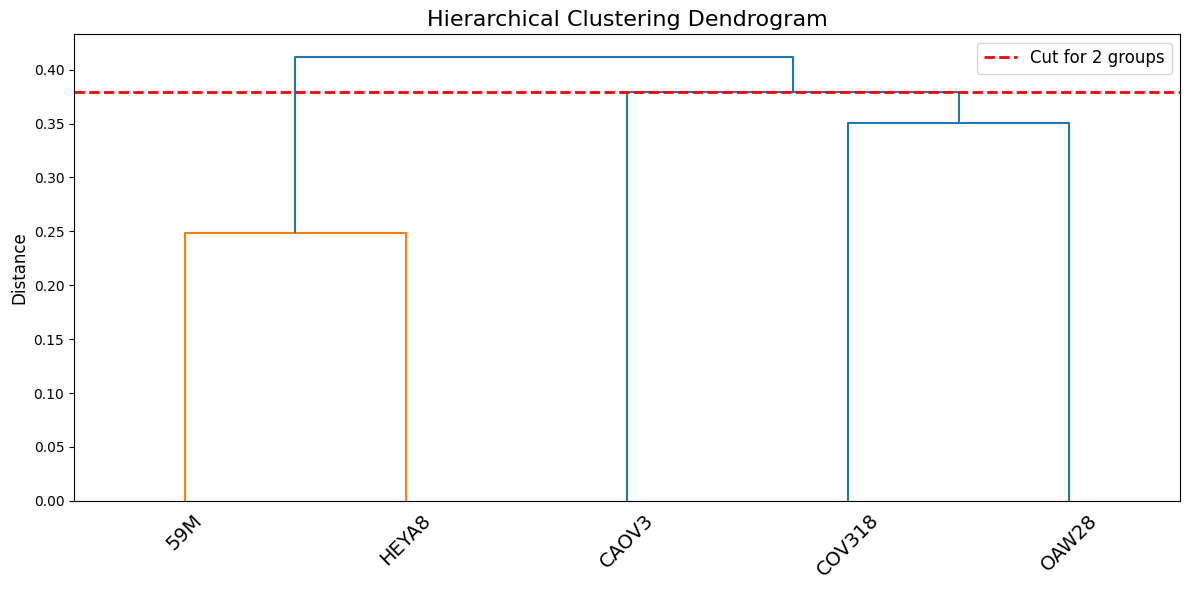

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage

cell_names = ['COV318', 'CAOV3', 'OAW28', '59M', 'HEYA8', 'OV56']  # last 2 are LG

name_to_ach = {
    'COV318': 'ACH-000256',
    'CAOV3': 'ACH-000713',
    'OAW28': 'ACH-000116',
    '59M': 'ACH-000520',
    'HEYA8': 'ACH-000542'
    'OV56' : 'ACH-000091'
}


def get_distribution_peak(series, bins=30):
    """Find the peak (mode) of distribution using histogram"""
    counts, edges = np.histogram(series, bins=bins)
    peak_idx = np.argmax(counts)
    return (edges[peak_idx] + edges[peak_idx + 1]) / 2

# ----- 1. Compute feature vectors -----
feature_vectors = {}

for name in cell_names:
    ach_id = name_to_ach[name]

    df = pd.read_csv(f'./flux_samples/{ach_id}.csv', index_col=0)

    stats = {
        'peak': df.apply(get_distribution_peak)
    }
    
    vec = pd.concat(stats, axis=0)
    feature_vectors[name] = vec

matrix = pd.DataFrame(feature_vectors).T

# ----- 2. Compute distances -----
dist = pairwise_distances(matrix, metric='cosine')

# ----- 3. Hierarchical clustering -----
linkage_matrix = linkage(dist[np.triu_indices_from(dist, k=1)], method='ward')

# ----- 4. Plot dendrogram -----
plt.figure(figsize=(12, 6))
dendrogram(
    linkage_matrix, 
    labels=cell_names, 
    leaf_font_size=14,
    leaf_rotation=45
)
plt.axhline(y=linkage_matrix[-2, 2], c='red', linestyle='--', linewidth=2, label='Cut for 2 groups')
plt.title("Hierarchical Clustering Dendrogram", fontsize=16)
plt.ylabel("Distance", fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()